In [1]:
import json
import new_env

/home/sean/Documents/venvs/jax/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("dataset.json") as fp:
    dataset = json.load(fp)


env = new_env.HolEnv("T")
paper_goals = []
for goal in dataset:
    try:
        p_goal = env.get_polish(goal)
        paper_goals.append((p_goal[0]["polished"]['goal'], goal))
    except:
        print (goal)

Importing theories...
Loading modules...
Configuration done.
DATATYPE ((sum :(α -> α + β) -> (β -> α + β) -> γ) (INL :α -> α + β) (INR :β -> α + β))
∀(A :α -> bool) (B :β -> bool) (C :α -> bool) (D :β -> bool). A × B ∩ (C × D) = A ∩ C × (B ∩ D)
DATATYPE ((list :α list -> (α -> α list -> α list) -> bool) ([] :α list) (CONS :α -> α list -> α list))


In [3]:
polished = [i for i in map(lambda x: x[0], paper_goals)]

In [4]:
#[i for i in map(lambda x: (x.value, x._type, x.arity), x)]

In [296]:
class AST:
    def __init__(self, node, children=[]):
        self.node = node
        self.children = children
    def _print(self, depth=1):
        print (depth * "--- " + self.node.value)
        if len(self.children) > 0:
            for child in self.children:
                child._print(depth+1)
        
class Token:
    def __init__(self, value, _type, arity=None):
        self.value = value
        self._type = _type
        self.arity = arity
    
#assume ast has been passed with ast.node as function 
def func_to_ast(ast, tokens, arity):
    if len(tokens) == 0:
        return ast

    node = tokens[0]
    tokens.pop(0)

    new_node = AST(node, children = [])
    
    if node._type == "variable":

        ast.children.append(new_node)

    elif node._type == "func" or node._type == "quantifier":

        new_ast = func_to_ast(new_node, tokens, node.arity)
        ast.children.append(new_ast)
      
        
    if arity == 1:
        return ast
    else:
        return func_to_ast(ast, tokens, arity-1)
    
def tokens_to_ast(tokens):
    ast = AST(tokens[0], children=[])
    tokens.pop(0)
    return func_to_ast(ast, tokens, ast.node.arity)


In [297]:
def polished_to_tokens_2(goal):
    polished_goal = goal.split(" ")
    tokens = []
    
    while len(polished_goal) > 0:
        if polished_goal[0] == '@':
            polished_goal.pop(0)
            arity = 1
            
            while polished_goal[0] == '@':
                arity += 1
                polished_goal.pop(0)
                
            func = polished_goal[0]
            polished_goal.pop(0)
            
            #quantifiers should be considered with arity 2 for constructing the tree (for now?)?
            if func == 'C$bool$' and (polished_goal[0] == '!' or polished_goal[0] == '?'):
                    arity = 2
                    #as there's 2 space separated characters for quantifiers
                    func = func + "|" + polished_goal[0] #+ polished_goal[1]
                    polished_goal = polished_goal[2:]
                    tokens.append(Token(func, "quantifier", arity))

                    
            else:
                if func[0] == 'C':
                    #should only be one string after the library 
                    func = func + "|" + polished_goal[0]
                    polished_goal.pop(0)
                #otherwise variable func, and nothing following it
                
                tokens.append(Token(func, "func", arity))
        
        #variable or constant case
        else:
            var = polished_goal[0]
            polished_goal.pop(0)
            if var[0] == "C":
                #need to append this and the next as constants are space separated
                var = var + polished_goal[0]
                polished_goal.pop(0)
                
            tokens.append(Token("".join(var), "variable"))
            
    return tokens
            

In [298]:
import networkx as nx
import matplotlib.pyplot as plt

In [299]:
def hierarchy_pos(G, root, levels=None, width=1., height=1.):
    '''If there is a cycle that is reachable from root, then this will see infinite recursion.
       G: the graph
       root: the root node
       levels: a dictionary
               key: level number (starting from 0)
               value: number of nodes in this level
       width: horizontal space allocated for drawing
       height: vertical space allocated for drawing'''
    TOTAL = "total"
    CURRENT = "current"
    def make_levels(levels, node=root, currentLevel=0, parent=None):
        """Compute the number of nodes for each level
        """
        if not currentLevel in levels:
            levels[currentLevel] = {TOTAL : 0, CURRENT : 0}
        levels[currentLevel][TOTAL] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                levels =  make_levels(levels, neighbor, currentLevel + 1, node)
        return levels

    def make_pos(pos, node=root, currentLevel=0, parent=None, vert_loc=0):
        dx = 1/levels[currentLevel][TOTAL]
        left = dx/2
        pos[node] = ((left + dx*levels[currentLevel][CURRENT])*width, vert_loc)
        levels[currentLevel][CURRENT] += 1
        neighbors = G.neighbors(node)
        for neighbor in neighbors:
            if not neighbor == parent:
                pos = make_pos(pos, neighbor, currentLevel + 1, node, vert_loc-vert_gap)
        return pos
    if levels is None:
        levels = make_levels({})
    else:
        levels = {l:{TOTAL: levels[l], CURRENT:0} for l in levels}
    vert_gap = height / (max([l for l in levels])+1)
    return make_pos({})

In [300]:
def print_graph(ast):
    G = nx.DiGraph()
    add_node(ast, G)
    
    labels = nx.get_node_attributes(G, 'value')
    pos = hierarchy_pos(G,ast.node)    
    plt.figure(1,figsize=(10,10)) 
    nx.draw(G, pos=pos, labels=labels, with_labels=True,
            arrowsize=20,
            node_color='none',
            node_size=6000)#, font_weight='bold')
    
    ax = plt.gca() # to get the current axis
    ax.collections[0].set_edgecolor("#FF0000") 
    plt.show()
# 0

def add_node(ast, graph):
    graph.add_node(ast.node, value = str(ast.node.value))
    for child in ast.children:
        graph.add_edge(ast.node, child.node)
        add_node(child, graph)
    
#verticalalignment='bottom'

In [301]:
#merge leaves - find all nodes with no children, take the set of them and make original parents point to new entity in the set
#connect quantifiers - given quantifier, traverse tree fully and point to any variables matching original quantified variable 



In [302]:
def add_quantified_children(quantifier_ast):
    var = quantifier_ast.children[0].node.value
    sub_tree = quantifier_ast.children[1]
    
    def apply_quantifier(ast, var):
        if ast.node.value == var:
            quantifier_ast.children.append(ast)
            for child in ast.children:
                apply_quantifier(child,var) 
        else:
            for child in ast.children:
                apply_quantifier(child,var)
        return
    
    apply_quantifier(sub_tree, var)
    return quantifier_ast
    

In [308]:
def process_quantifiers(ast):
    if ast.node._type == 'quantifier':
        add_quantified_children(ast)
        for child in ast.children:
            process_quantifiers(child)
    else:
        for child in ast.children:
            process_quantifiers(child)
    return 


In [320]:


leaves = []

def get_leaves(ast):
    if ast.children == []:
        leaves.append(ast.node)
    else:
        for child in ast.children:
            get_leaves(child)
    return
get_leaves(test2)
set([x for x in leaves])

def merge_leaves(ast):
    leaves = []

    def get_leaves(ast):
        if ast.children == []:
            leaves.append(ast.node)
        else:
            for child in ast.children:
                get_leaves(child)
        return
    
    get_leaves(ast)
    
    leaf_tokens = set(leaves)
    leaf_values = set([x.value for x in leaves])
    
    def get_parents(node):
        #add data to ast structure to include parent!
    
    
    for value in leaf_values:
        

{<__main__.Token at 0x7f22109ab6d0>,
 <__main__.Token at 0x7f2210ad7490>}

('@ C$bool$ ! | Vs @ C$bool$ ! | Vt @ C$bool$ ! | Vx @ @ C$min$ = @ @ C$bool$ IN Vx @ @ C$pred_set$ DIFF Vs Vt @ @ C$bool$ /\\ @ @ C$bool$ IN Vx Vs @ C$bool$ ~ @ @ C$bool$ IN Vx Vt', '∀(s :α -> bool) (t :α -> bool) (x :α). x ∈ s DIFF t ⇔ x ∈ s ∧ x ∉ t')


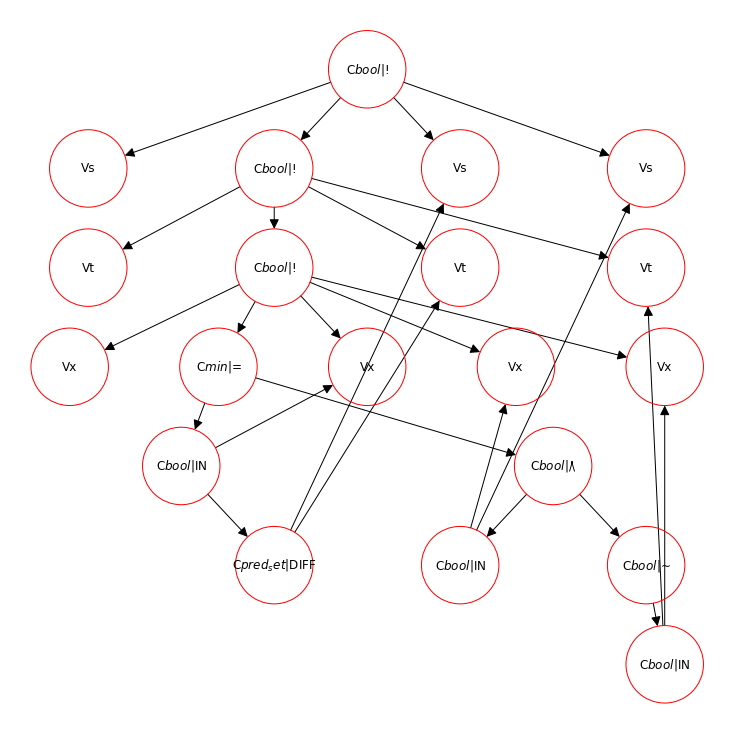

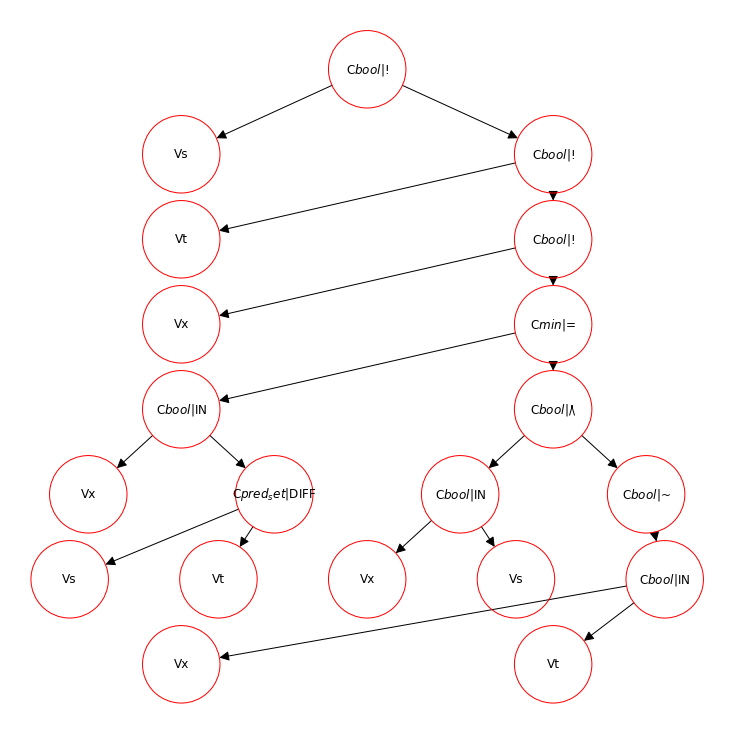

In [317]:
i = 10

x = polished_to_tokens_2(polished[i])
test = tokens_to_ast(x)
#print_graph(test)
print (paper_goals[i])

test2 = copy.deepcopy(test)

process_quantifiers(test2)

print_graph(test2)
print_graph(test)

In [ ]:
# x = Token("x", "func", 2)
# plus = Token("+", "func", 2)
# neg = Token("-", "func", 1)
# two = Token("2", "variable")
# five = Token("5", "variable")
# seven = Token("7", "variable")
# f = Token("f", "func", 3)
# tokens = [x, neg, two, plus, five, f, two, five, seven]

# ast_ = AST(x)

# tokens.pop(0)

# new_ast = func_to_ast(ast_, tokens, 2)

In [189]:
# def polished_to_tokens(goal):
#     polished_goal = goal.replace(" ", "")
#     tokens = []
#     polished_goal = list(polished_goal)
    
#     while len(polished_goal) > 0:
#         if polished_goal[0] == '@':
#             polished_goal.pop(0)
#             arity = 1
#             while polished_goal[0] == '@':
#                 arity += 1
#                 polished_goal.pop(0)
#             func = []
#             #if variable straight after @, indicates variable function
#             if polished_goal[0] == "V":
#                 polished_goal.pop(0)
            
#             while polished_goal[0] != 'V' and polished_goal[0] != '@':
#                 func.append(polished_goal[0])
#                 polished_goal.pop(0)
#             func = "".join(func)
#             #quantifiers should be considered with arity 2 for constructing the tree (for now?)?
#             if func == 'C$bool$!|' or func == 'C$bool$?|':
#                 arity = 2
#             tokens.append(Token(func, "func", arity))
        
#         elif polished_goal[0] == "V":
#             var = []
#             polished_goal.pop(0)
#             while polished_goal[0] != 'V' and polished_goal[0] != '@':
#                 var.append(polished_goal[0])
#                 polished_goal.pop(0)
#                 if len(polished_goal) == 0:
#                     break
#             tokens.append(Token("".join(var), "variable"))
            
            
#         else:
#             print ("confused")
            
#     return tokens
            
            
        